## Import standard libraries

In [5]:
# Import custom libraries from local folder.
from importlib import reload
import os
import sys
sys.path.append("..")

# Import nn module from torch to replicate kessler tool
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Import json library and create function to format dictionaries.
import json
format_json = lambda x: json.dumps(x, indent=4)

# Import utils library containing miscellaneous functions/classes
from scalib import utils

# Import SCALIB modules for NN development
import scalib.xnn as xnn            # NN models
import scalib.utils as utils
import scalib.eda as eda
import scalib.cfg as cfg

# Set overall seed for reproducibility
utils.seed(1)

# Import matplotlib library and setup environment for plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
from matplotlib import rc

# Set rendering parameters to use TeX font if not working on Juno app.
if not '/private/var/' in utils.cwd:
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 11})
    rc('text', usetex=True)
    
# Get current working directory path for the tool parent folder and print it.
print('Parent working directory: %s' % utils.cwd)


Parent working directory: /Users/jjrr/Documents/SCA-Project/scalib


## Import training dataset

In [6]:
# Import library to import Kelvins challlenge data
from scalib.eda import kelvins_challenge_events

# Import Kelvins dataset and convert it to dataframes in CCSDS format
for filename in ['test_data.csv', 'train_data.csv']:

    filepath_dest = os.path.join(utils.cwd,'data','ccsds', filename)
    filepath_orig = os.path.join(utils.cwd,'data','esa-challenge', filename)

    if os.path.exists(filepath_dest):
        df = pd.read_csv(filepath_dest, index_col=0)
    else:

        # Get ConjunctionEventsDataset object 
        events = kelvins_challenge_events(filepath_orig,
                    drop_features = ['c_rcs_estimate', 't_rcs_estimate'])

        # Convert Conjunction Events Dataset to pandas DataFrame and save it.
        df = events.to_dataframe(event_id=True)
        df.to_csv(filepath_dest)
        
display(df.head(5))

,CCSDS_CDM_VERS,CREATION_DATE,ORIGINATOR,MESSAGE_FOR,MESSAGE_ID,TCA,MISS_DISTANCE,RELATIVE_SPEED,RELATIVE_POSITION_R,RELATIVE_POSITION_T,...,OBJECT2_CTHR_NDOT,OBJECT2_CTHR_DRG,OBJECT2_CTHR_SRP,OBJECT2_CTHR_THR,__MAX_RISK_ESTIMATE,__MAX_RISK_SCALING,__CREATION_DATE,__TCA,__DAYS_TO_TCA,__EVENT_ID
0,1.0,2023-09-20T07:30:55.604684,NaN,NaN,NaN,2023-09-21T21:07:06.971684,14923.0,13792.0,453.8,5976.6,...,NaN,NaN,NaN,NaN,-7.834756,8.602101,0.000000,1.566798,1.566798,0
1,1.0,2023-09-20T16:08:19.532684,NaN,NaN,NaN,2023-09-21T21:07:06.971684,14544.0,13792.0,474.3,5821.2,...,NaN,NaN,NaN,NaN,-7.848937,8.956374,0.359305,1.566798,1.207494,0
2,1.0,2023-09-20T22:15:57.518684,NaN,NaN,NaN,2023-09-21T21:07:06.971684,14475.0,13792.0,474.6,5796.2,...,NaN,NaN,NaN,NaN,-7.847406,8.932195,0.614605,1.566798,0.952193,0
3,1.0,2023-09-21T07:12:23.538684,NaN,NaN,NaN,2023-09-21T21:07:06.971684,14579.0,13792.0,472.7,5838.9,...,NaN,NaN,NaN,NaN,-7.845880,8.913444,0.987129,1.566798,0.579669,0
4,1.0,2023-09-21T14:55:52.529684,NaN,NaN,NaN,2023-09-21T21:07:06.971684,14510.0,13792.0,478.7,5811.1,...,NaN,NaN,NaN,NaN,-7.852942,9.036838,1.308992,1.566798,0.257806,0


In [7]:
# Cast columns as correct dtypes
convert_dict = dict()

# Iterate over all objects
for o in [1, 2]:

    # Iterate over all features in a CDM
    for feature, information in cfg.cdm_features.items():

        # Get the cluster of the CDM data.
        cluster = information['cluster']

        if (cluster.startswith('header') or cluster.startswith('relative')) and o==1:
             xfeature = feature
        elif not (cluster.startswith('header') or cluster.startswith('relative')):
            xfeature = f'OBJECT{o}_{feature}'

        if xfeature in convert_dict.keys(): continue
        #if xfeature not in df.columns: continue
        convert_dict[xfeature] = information['dtype']

df = df.astype(convert_dict)


In [8]:
reload(cfg)
# Get list of obligatory features.
features = cfg.get_features(only_names=True,include_object_preffix=True, 
                            **dict(obligatory=True, cluster='data_covariance'))

# Segregate numerical from categorical features
#cat_features = [f for f in features if df[f].dtype=='category']
cat_features=['OBJECT1_OBJECT_TYPE', 'OBJECT2_OBJECT_TYPE']

num_features = [f for f in features if f in df._get_numeric_data().columns]
num_features.append('__DAYS_TO_TCA')
out_features = ['COLLISION_PROBABILITY']

features = features + ['COLLISION_PROBABILITY', '__MAX_RISK_ESTIMATE', '__MAX_RISK_SCALING']
df_ann = df[out_features + num_features + cat_features]

display(df_ann.head(5))
display(df_ann.describe())

# print(f'Output features:\n' + utils.tabular_list(out_features, n_cols=3, col_sep = ' - '))
# print(f'Input Categorical features:\n' + utils.tabular_list(cat_features, n_cols=3, col_sep = ' - '))
# print(f'Input Continuous features:\n' + utils.tabular_list(con_features, n_cols=3, col_sep = ' - '))

,COLLISION_PROBABILITY,OBJECT1_CR_R,OBJECT2_CR_R,OBJECT1_CT_R,OBJECT2_CT_R,OBJECT1_CT_T,OBJECT2_CT_T,OBJECT1_CN_R,OBJECT2_CN_R,OBJECT1_CN_T,...,OBJECT2_CNDOT_N,OBJECT1_CNDOT_RDOT,OBJECT2_CNDOT_RDOT,OBJECT1_CNDOT_TDOT,OBJECT2_CNDOT_TDOT,OBJECT1_CNDOT_NDOT,OBJECT2_CNDOT_NDOT,__DAYS_TO_TCA,OBJECT1_OBJECT_TYPE,OBJECT2_OBJECT_TYPE
0,-10.204955,16.466810,71140.79,-222.242200,-11961160.0,18938.4700,2.955756e+09,2.112694,5892.756,10.002140,...,13.00946,9.316645e-07,-4.434362,-0.000002,-0.042638,0.000009,0.149353,1.566798,PAYLOAD,UNKNOWN
1,-10.355758,12.438180,68744.55,-14.462720,-11602080.0,3143.8580,2.924870e+09,1.888744,5897.834,6.113387,...,12.99737,-9.040335e-07,-4.390144,-0.000002,-0.042872,0.000009,0.149300,1.207494,PAYLOAD,UNKNOWN
2,-10.345631,11.303290,68469.38,-13.770550,-11555830.0,1406.0960,2.918959e+09,1.869411,5898.712,2.986285,...,12.99521,-2.763477e-06,-4.381993,-0.000001,-0.042886,0.000009,0.149290,0.952193,PAYLOAD,UNKNOWN
3,-10.337809,9.460428,68518.15,1.476252,-11579220.0,494.3005,2.927633e+09,2.380359,5899.596,6.398545,...,12.99755,-3.218169e-06,-4.394314,-0.000002,-0.042897,0.000009,0.149305,0.579669,PAYLOAD,UNKNOWN
4,-10.391260,11.506860,67978.79,22.836610,-11501960.0,259.5581,2.922881e+09,2.697022,5901.675,7.789963,...,12.99492,-6.967915e-06,-4.387243,-0.000003,-0.042947,0.000010,0.149296,0.257806,PAYLOAD,UNKNOWN


,COLLISION_PROBABILITY,OBJECT1_CR_R,OBJECT2_CR_R,OBJECT1_CT_R,OBJECT2_CT_R,OBJECT1_CT_T,OBJECT2_CT_T,OBJECT1_CN_R,OBJECT2_CN_R,OBJECT1_CN_T,...,OBJECT2_CNDOT_T,OBJECT1_CNDOT_N,OBJECT2_CNDOT_N,OBJECT1_CNDOT_RDOT,OBJECT2_CNDOT_RDOT,OBJECT1_CNDOT_TDOT,OBJECT2_CNDOT_TDOT,OBJECT1_CNDOT_NDOT,OBJECT2_CNDOT_NDOT,__DAYS_TO_TCA
count,127037.000000,127037.000000,127037.000000,127037.000000,1.270370e+05,1.270370e+05,1.270370e+05,127037.000000,127037.000000,127037.000000,...,127037.000000,127037.000000,127037.000000,1.270370e+05,127037.000000,1.270370e+05,127037.000000,1.270370e+05,127037.000000,127037.000000
mean,-20.182834,35.908156,35337.640692,-161.193973,-5.336295e+05,6.413597e+04,2.983188e+08,2.048410,1397.369264,-0.298369,...,-18.861943,0.002860,8.147357,8.414212e-08,0.016910,-1.652280e-06,-0.007410,1.775709e-05,0.059481,3.233928
std,10.048709,47.214457,99302.366104,1021.840070,4.703970e+06,2.787267e+05,1.002829e+09,6.624918,21501.546569,68.966087,...,1366.346422,0.008620,49.435199,1.662945e-04,1.399574,9.021418e-06,0.065199,2.621128e-05,0.346754,1.998297
min,-30.000000,0.489294,0.979248,-33897.670017,-9.724996e+07,6.751638e+00,2.476385e+01,-114.030710,-296147.602180,-3854.640162,...,-84097.108281,-0.278727,-598.965953,-1.731301e-02,-27.846360,-2.793286e-04,-1.867386,9.338203e-07,0.000002,-0.149808
25%,-30.000000,8.801788,755.641200,-91.204460,-1.941400e+05,8.281851e+02,7.399137e+05,0.019425,-196.835944,-5.417089,...,-18.637033,-0.000342,-0.033137,-8.001356e-06,-0.016701,-2.806627e-06,-0.002946,7.346501e-06,0.000723,1.483597
50%,-22.846185,20.032789,3531.500184,-15.135134,-1.206874e+04,5.102538e+03,9.963152e+06,1.174872,62.336851,0.007857,...,-0.001395,0.001842,0.273539,3.053044e-08,0.000008,-8.892520e-07,-0.000225,1.118877e-05,0.003470,3.127263
75%,-9.646084,44.341040,19450.890000,6.497921,7.550018e+02,2.458334e+04,9.863982e+07,3.665642,1309.808000,4.920443,...,15.755460,0.004218,3.522144,7.638839e-06,0.020216,2.540593e-07,0.000075,1.713301e-05,0.018044,4.922865
max,-1.442854,399.896163,999653.817275,36646.610000,9.537125e+07,3.998408e+06,9.997002e+09,102.910689,344779.700000,7617.330916,...,32678.080000,0.211840,1107.883000,2.422636e-02,83.183784,8.555327e-04,2.558004,2.220647e-03,21.840158,6.993832


## Aritificial Neural Network model for Collision Risk Probability Estimation (CRPE)

#### Embedding categorical input features

An embedding is a vector representation of a categorical variable. The representation of this vector is computed through the use of NN models/techniques that take into account potential relation between categories in order to create the vector representation for each category.

In practice, an embedding matrix is a lookup table for a vector. Each row of an embedding matrix is a vector for a unique category.

The main advantadge of using embeddings instead of One Hot/Dummy Encoding techniques (one column per unique value of categorical feature with 0s and 1s) is that it can preserve the natural order and common relationships between the categorical features. For example, we could represent the days of the week with 4 floating-point numbers each, and two consecutive days would look more similar than two weekdays that are days apart from each other.


The rule of thumb for determining the embedding size (number of elemens per array) is to divide the number of unique entries in each column by 2, but not to exceed 50.

In [9]:
# Set overall seed for reproducibility
utils.seed(1)

# Initialise dropout operation to prevent overfitting in the embeddings tensors
dropout = nn.Dropout(p=0.2)

# Apply batch normalisation to continuous variables
bn_nums = nn.BatchNorm1d(len(num_features))

# Get Torch for output features
y = np.stack([df[f].to_numpy() for f in out_features], 1)
y = torch.tensor(y, dtype=torch.float) 

# Get Torch for all continuous features
nums = np.stack([df[f].to_numpy() for f in num_features], 1)
nums = torch.nan_to_num(torch.tensor(nums, dtype=torch.float))

# Normalize continuous variables
X_num = bn_nums(nums)
# X_num = nums

# Get Torch for all categorical features
cats = np.stack([df[f].cat.codes.values for f in cat_features], 1)
cats = torch.tensor(cats, dtype=torch.int)

# This will set embedding sizes for the categorical columns:
# an embedding size is the length of the array into which every category
# is converted
cat_szs = [len(df[f].cat.categories) for f in cat_features]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]

# Initialize list of embedding operations.
#  - nuv = Number of unique vectors
#  - nvc = Number of vector componets
embeddings = nn.ModuleList([nn.Embedding(nuv, nvc) for nuv, nvc in emb_szs])

# Initialize embeddings list
embeddings_tensors = []

# Apply embedding operation to every column of categorical tensor
for i, embedding in enumerate(embeddings):
    #print(cats[:,i])
    embeddings_tensors.append(embedding(cats[:,i]))

# Concatenate embedding sections into 1
X_cat = torch.cat(embeddings_tensors, 1)

# Apply dropout function to the embeddings torch
#X_cat = embeddings_dropout(x_cat)

for f, feature in enumerate(cat_features):
    print(f'Feature: {feature:30s} | Embedding size: {emb_szs[f]} |'
          f' Unique vectors: {emb_szs[f][0]} | Length: {emb_szs[f][1]}')
    
# Concatenate embeddings with continuous variables into one torch
X = torch.cat([X_cat, X_num], 1)

Feature: OBJECT1_OBJECT_TYPE            | Embedding size: (1, 1) | Unique vectors: 1 | Length: 1
Feature: OBJECT2_OBJECT_TYPE            | Embedding size: (5, 3) | Unique vectors: 5 | Length: 3


In [10]:
# Compute total number of inputs to pass to the initial layer (data 
# point = Nb. of embeddings + Nb. of continuous variables)


input_size = X.size(1)
output_size = y.size(1)

n_in = input_size

layers=[input_size*4, input_size*2, input_size]
p = 0.2

network = nn.ModuleList()

# Run through every layer to set up the operations to perform per layer.
# (i.e. layers=[100, 200, 100])
network = nn.ModuleList()
for l, n_neurons in enumerate(layers):
    # On layer l, which contains n_neurons, perform the following 
    # operations:
    # 1. Apply Linear neural network model regression (fully connected 
    # network -> z = Sum(wi*xi+bi))
    network.append(nn.Linear(n_in,n_neurons))
    
    # 2. Apply ReLU activation function (al(z))
    network.append(nn.ReLU())
    
    # 3. Normalize data using the n_neurons
    network.append(nn.BatchNorm1d(n_neurons))
    
    # 4. Cancel out a random proportion p of the neurons to avoid 
    # overfitting
    network.append(nn.Dropout(p))
    
    # 5. Set new number of input features n_in for the next layer l+1.
    n_in = n_neurons

# Set the last layer of the list which corresponds to the final output
network.append(nn.Linear(layers[-1], output_size))

print(network)

ModuleList(
  (0): Linear(in_features=47, out_features=188, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(188, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=188, out_features=94, bias=True)
  (5): ReLU()
  (6): BatchNorm1d(94, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.2, inplace=False)
  (8): Linear(in_features=94, out_features=47, bias=True)
  (9): ReLU()
  (10): BatchNorm1d(47, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Dropout(p=0.2, inplace=False)
  (12): Linear(in_features=47, out_features=1, bias=True)
)


### Split dataset into train and test datasets

In [5]:
# Get test and training sizes
train_split = 0.80
train_size = int((X.size(0)*train_split))
test_size = X.size(0) - train_size

# Get tensor with inputs and targets data
X_train = X[:train_size-test_size]
y_train = y[:train_size-test_size]

X_test = y[train_size-test_size:train_size]
y_test = y[train_size-test_size:train_size]

Train size: 121000 	 Test size: 41634


### Initialize CollisionRisk model

In [ ]:


# Define Collision Risk Probability Estimator
class CollisionRiskProbabilityEstimator(nn.Module):

    def __init__(self, input_size:int, output_size:int, network:list):
        
        # Inherit attributes from nn.Module class
        super().__init__()

        # Initialise input and output sizes
        self.input_size = input_size
        self.output_size = output_size

        # Set model using the modules parameter
        self.netwrk = network

        # Initialize dictionary to store training results
        self._learn_results = {'total_iterations':[],
                               'validation_loss':[],
                               'training_loss':[],
                               'epoch':[],
                               'learning_rate':[],
                               'batch_size':[]}

                               
    def plot_loss(self, filepath:str = None, figsize:tuple = (6, 3), 
                  log_scale:bool = False, validation_only:bool=False, 
                  plot_lr:bool=False, label:str = None,
                  ax:plt.Axes = None, return_ax:bool = False) -> None:
        """Plot RNN loss in the training set (orange) and validation set (blue) 
        vs number of iterations during model training.

        Args:
            filepath (str, optional): Path where the plot is saved. Defaults to 
            None.
            figsize (tuple, optional): Size of the plot. Defaults to (6 ,3).
            log_scale (bool, optional): Flag to plot Loss using logarithmic 
            scale. Defaults to False.
            plot_lr (bool, optional): Include learning rate evolution during
            training. Defaults to False.
        """

        # Apply logarithmic transformation if log_scale is set to True. This 
        # helps to see the evolution when variations between iterations are 
        # small.
        iterations = self._learn_results['total_iterations']

        
        # Create axes instance if not passed as a parameter.
        if ax is None: fig, ax = plt.subplots(figsize=figsize)

        # Plot loss vs iterations.
        colors = ['tab:orange', 'tab:blue']

        for p, process in enumerate(['training', 'validation']):

            if process=='training' and validation_only: continue

            loss = self._learn_results[f'{process}_loss']
            loss = pd.Series(np.log(loss) if log_scale else loss, 
                                iterations).drop_duplicates(keep='first')

            ax.plot(loss, color = colors[p], 
                    label = process.capitalize() if label is None else label)

            # Set X-axis limits.
            if process=='validation': ax.set_xlim(0, loss.index.max())
        

        # Plot learning rate if required
        if plot_lr:

            # Get learning rate
            lr = pd.Series(self._learn_results['learning_rate'], 
                           iterations)
            
            # Add right axis to plot learning rate.
            ax_lr = ax.twinx()

            ax_lr.set_ylabel('Learning rate', color = 'tab:green')  
            ax_lr.set_ylim(0, lr.max()*1.25)
            ax_lr.plot(lr, label='Learning rate', color = 'tab:green')
        


        # Set axes labels.
        ax.set_xlabel('Number of iterations')
        ax.set_ylabel('MSE Loss')

        # Set legend and grid for better visualization.
        ax.legend(fontsize=8)
        ax.grid(True, linestyle='--')

        # Save figure if filepath is provided.
        if filepath is not None:
            print('Plotting to file: {}'.format(filepath))
            fig.savefig(filepath)

        if return_ax:
            return ax
        

    def learn(self, X_train, y_train, epochs:int = 2, lr:float = 1e-3, 
              batch_size:int = 8, device:str = None, 
              valid_proportion:float = 0.15, num_workers:int = 4, 
              filepath:str = None,
              epoch_step_checkpoint:int = None, **kwargs) -> None:
        """Train RNN model.

        Args:
            event_set (list): List of Conjunction Event objects to use for 
            training (including validationd data).
            epochs (int, optional): Number of epochs used for training. Defaults 
            to 2.
            lr (float, optional): Learning rate. Defaults to 1e-3.
            batch_size (int, optional): Batch size. Defaults to 8.
            device (str, optional): Device where torchs are allocated. Defaults 
            to 'cpu'.
            valid_proportion (float, optional): Proportion of all data used for 
            validation (value must be between 0 and 1). Defaults to 0.15.
            num_workers (int, optional): _description_. Defaults to 4.
            event_samples_for_stats (int, optional): Number of events considered 
            to compute the mean and standard deviation used for normalization. 
            Defaults to 250.
            filepath (str, optional): Filepath for the model 
            to be saved. If None, model is not saved. Defaults to None.
            epoch_step_checkpoint (int, optional): Number of epochs to process 
            before saving a new checkpoint. Only applicable if filepath is
            not None. Defaults to None.

        Raises:
            ValueError: valid_proportion is not in the range (0, 1).
            RuntimeError: Validation set does not contain any event as a result 
            of valid_proportion being too low.
        """

        
        # Define the device on which the torch will be allocated:
        device = torch.device('cpu') if device is None else torch.device(device)

        self._device = device
        self.to(device)

        # Get number of parameters in the model.
        num_params = sum(p.numel() for p in self.parameters())
        print(f'Number of learnable parameters of the model: {num_params:,}')


        # Check valid_proportion is between 0.0 and 1.0
        if valid_proportion<0 or valid_proportion>1.0:
            raise ValueError('Parameter valid_proportion ({})'+ \
                             ' must be greater than 0 and lower than 1' \
                             .format(valid_proportion))

        # Compute the size of the validation set from valid_proportion.
        valid_set_size = int(len(data) * valid_proportion)
        
        # Check size of validation set is greater than 0.
        if valid_set_size == 0:
            raise RuntimeError('Validation set size is 0 for the given' + \
                               ' valid_proportion ({}) and number of ' + \
                               'events ({})' \
                               .format(valid_proportion, len(data)))
        
        # Get training set size.
        train_set_size = len(data) - valid_set_size

        # Set-up optimizer and criterion.
        self.optimizer = optim.Adam(self.parameters(), lr = lr)
        self.criterion = nn.MSELoss()


        # Check if the same model already exists. If it does, load model 
        # parameters.
        if filepath is not None and os.path.exists(filepath):
            self.load(filepath)
            self.optimizer.param_groups[0]['lr'] = lr
            print('\nModel parameters loaded from {}\n'
                  ' - Total epochs       = {}\n'
                  ' - Total iterations   = {}\n'
                  ' - Validation loss    = {:6.4e}\n'
                  ' - Last learning rate = {:6.4e}\n'
                  ''.format(filepath,
                            self._learn_results['epoch'][-1],
                            self._learn_results['total_iterations'][-1],
                            self._learn_results['validation_loss'][-1],
                            self._learn_results['learning_rate'][-1]))

        # Set training mode ON to inform layers such as Dropout and BatchNorm, 
        # which are designed to behave differently during training and 
        # evaluation. For instance, in training mode, BatchNorm updates a moving 
        # average on each new batch; whereas, for evaluation mode, these updates 
        # are frozen.
        self.train()
        
        if len(self._learn_results['total_iterations']) == 0:
            total_iters = 0
            last_epoch = 0
        else:
            total_iters = self._learn_results['total_iterations'][-1]
            last_epoch = self._learn_results['epoch'][-1]


        X_valid = X_train[train_set_size:]
        y_valid = y_train[train_set_size:]

        X_train = X_train[:train_set_size]
        y_train = y_train[:train_set_size]


        pb_epochs = utils.ProgressBar(iterations=range(epochs),
                        title = 'TRAINING COLLISION RISK ESTIMATOR MODEL:')

        for epoch in range(epochs):

            total_iters += 1

            if (epoch+1)%10==0 or epoch==0:
                with torch.no_grad():
                    y_pred = self.forward(X_valid)
                    loss = self.criterion(y_pred, y_valid)
                    valid_loss = float(loss)


            # Clear all the gradients of all the parameters of the model.
            y_pred = self.forward(X_train)

            # Compute MSE loss using criterion and store it in an array.
            loss = self.criterion(y_pred, y_train)
            train_loss = float(loss)

            # Backpropagate MSE loss.
            self.optimizer.zero_grad()
            loss.backward(retain_graph=True)

            # Update model hyperparameters taking into account the loss.
            self.optimizer.step()

            # Update progress bar.
            description = f'E({epoch+1}/{epochs}) |' + \
                f'Loss > T({train_loss:6.4e}) ' + \
                f'V({valid_loss:6.4e})'

            pb_epochs.refresh(i = epoch+1, 
                                description = description,
                                nested_progress = True)
            

            # Save training information.
            self._learn_results['total_iterations'].append(total_iters)
            self._learn_results['validation_loss'].append(valid_loss)
            self._learn_results['training_loss'].append(train_loss)
            self._learn_results['epoch'].append(last_epoch + epoch + 1)
            self._learn_results['learning_rate'].append(lr)
            self._learn_results['batch_size'].append(batch_size)

                    

        # Print message at the end of the mini batch.
        pb_epochs.refresh(i = epoch+1, description = description)


    def forward(self, x):

        # Iterate over all modules to perform the forward operation.
        for layer in self.network:
            x = layer(x)
        
        return x

In [ ]:
class TabularModel(nn.Module):

    def __init__(self, input_size, output_size, network):
        
        # Inherit attributes from nn.Module class
        super().__init__()
        
        self.input_size = input_size
        self.output_size = output_size
        self.network = network
    
    def forward(self, x):
        
        # Process all data points with the layers functions (sequential of operations)
        for layer in self.network:
            x = layer(x)
        
        return x

In [ ]:
torch.manual_seed(33)
model = CollisionRiskProbabilityEstimator(input_size = X.size(1), 
                     output_size = y.size(1), 
                     network = network)

print(model)

Training Collision Risk model | MSE loss = 5.08157301 : 100%|██████████| 500/500 [05:13<00:00,  1.60it/s]  


Final MSE loss: 5.08157301
Traning duration: 313 seconds.
Saving model parameters... Done.



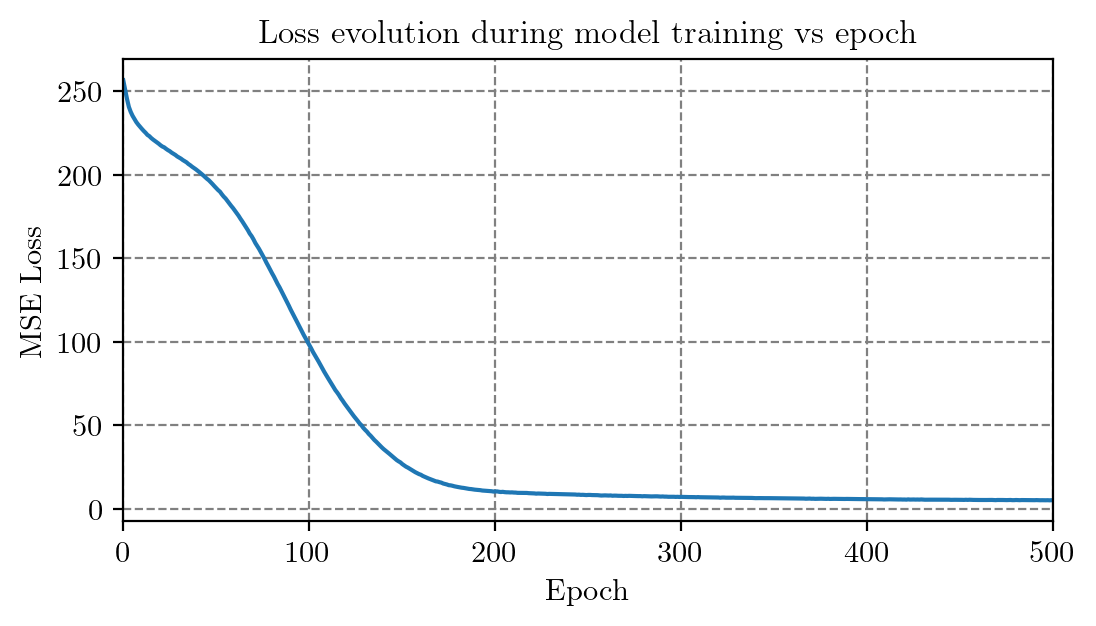

In [6]:
import time
from tqdm import trange
from library.irplib import ann

# Set manual seed
torch.manual_seed(33)

layers = [200, 400, 300, 100]
n_out = len(out_features)
n_conts = conts.shape[1]

# Define loss function (criterion)
criterion = nn.MSELoss()

# Initialize model from ann library
model = ann.CollisionRisk(emb_szs, n_conts, n_out, layers, p=0.4)

# Print model structure
model

# Get time-series sets for every continuous variable feature 
# (constant features by definition do not need to be forecasted)
model_filename = 'CollisionRiskModel.pt'

# Check if tensors pt file is available in the data folder
filepath = os.path.join(cwd,'models','ann', model_filename)

# Import model settings if exists
if os.path.exists(filepath):
    model.load_state_dict(torch.load(filepath))

    # Set dropout and batch normalization layers to evaluation mode before 
    # running inference.
    model.eval()

    print(f'Model parameters imported successfully from:\n{filepath}')
else:

    # Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002) 

    start_time = time.time()

    epochs = 500
    losses = np.ones(epochs)*np.inf

    t = trange(epochs, desc='Training Collision Risk model', leave=True)

    for e in t:
        
        # Predict values using the model
        y_pred = model(cat_train, con_train)

        # Compute loss using the criterion
        loss = criterion(y_pred, y_train)

        t.set_description(f'Training Collision Risk model ' + \
                          f'| MSE loss = {loss.item():10.8f} ')
        t.refresh() # to show immediately the update

        # Add computed loss to the losses array for analysis
        losses[e] = loss.detach().numpy()

        optimizer.zero_grad()

        # Backpropagate the loss
        loss.backward()

        # Adjust parameters of the optimizer 
        optimizer.step()

    print(f'\nFinal MSE loss: {losses[-1]:10.8f}'
          f'\nTraning duration: {time.time() - start_time:.0f} seconds.')

    # Save the model trained parameters (weights and biases)
    print('Saving model parameters...', end='\r')
    torch.save(model.state_dict(), filepath)
    print('Saving model parameters... Done.\n')

    # Plot loss evolution during training
    plt.figure(figsize=(6,3))
    plt.title(r'Loss evolution during model training vs epoch', fontsize=12)
    plt.plot(range(epochs), losses)
    plt.xlim(0, epochs)
    plt.ylabel('MSE Loss')
    plt.xlabel('Epoch')
    plt.grid(True, linestyle='--', c='grey')
    plt.show()




## Model evaluation

In [7]:
# Evaluate entire dataset
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = criterion(y_val, y_test)
print(f'MSE loss on test dataset: {loss:.8f}')

MSE loss on test dataset: 6.07023382


In [8]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score as accuracy, precision_score as precision
from sklearn.metrics import f1_score as f1, recall_score as recall

# Define risk threshold for collision avoidance manouvre.
risk_threshold = -4.0

# Get outputs from the model from the entire dataset.
output = []
for i in range(len(y_test)):
    y_pred = y_val[i][0].item()
    y_true = y_test[i][0].item()
    diff = np.abs(y_pred-y_true)

    output.append([y_pred, y_true, diff, y_pred>=risk_threshold, y_true>=risk_threshold])
    

# Create DataFrame with the results and print the first rows
df_val = pd.DataFrame(data=output, columns=['pred_risk','true_risk', 'delta', 'pred_avoidance_flag', 'true_avoidance_flag'])
display(df_val.head(10))

# Evaluate accuracy using the confusion matrix.
y_true = df_val['true_avoidance_flag']
y_pred = df_val['pred_avoidance_flag']

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

print(f'Model accuracy  = {accuracy(y_true, y_pred)*100:5.2f}%\n')
print(f'TP: {tp:^6} FP: {fp:^6}\n'
      f'FN: {fn:^6} TN: {tn:^6}')

,pred_risk,true_risk,delta,pred_avoidance_flag,true_avoidance_flag
0,-5.761452,-5.552532,0.208920,False,False
1,-20.565798,-30.000000,9.434202,False,False
2,-27.793129,-30.000000,2.206871,False,False
3,-33.290962,-30.000000,3.290962,False,False
4,-5.280630,-5.577574,0.296945,False,False
5,-26.958017,-30.000000,3.041983,False,False
6,-14.613995,-13.477035,1.136960,False,False
7,-29.446091,-30.000000,0.553909,False,False
8,-12.677701,-11.262410,1.415291,False,False
9,-6.876757,-8.261299,1.384542,False,False


Model accuracy  = 98.84%

TP:   34   FP:  340  
FN:  142   TN: 41118 



## Save the trained model to a file
Right now <strong><tt>model</tt></strong> has been trained and validated, and seems to correctly classify an iris 97% of the time. Let's save this to disk.<br>
The tools we'll use are <a href='https://pytorch.org/docs/stable/torch.html#torch.save'><strong><tt>torch.save()</tt></strong></a> and <a href='https://pytorch.org/docs/stable/torch.html#torch.load'><strong><tt>torch.load()</tt></strong></a><br>

There are two basic ways to save a model.<br>

The first saves/loads the `state_dict` (learned parameters) of the model, but not the model class. The syntax follows:<br>
<tt><strong>Save:</strong>&nbsp;torch.save(model.state_dict(), PATH)<br><br>
<strong>Load:</strong>&nbsp;model = TheModelClass(\*args, \*\*kwargs)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;model.load_state_dict(torch.load(PATH))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;model.eval()</tt>

The second saves the entire model including its class and parameters as a pickle file. Care must be taken if you want to load this into another notebook to make sure all the target data is brought in properly.<br>
<tt><strong>Save:</strong>&nbsp;torch.save(model, PATH)<br><br>
<strong>Load:</strong>&nbsp;model = torch.load(PATH))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;model.eval()</tt>

In either method, you must call <tt>model.eval()</tt> to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results.

For more information visit https://pytorch.org/tutorials/beginner/saving_loading_models.html